# Build 50LR-3HR Multi-Fidelity Emulator for Matter Power Spectrum

A notebook to reprduce the results of 50LR-3HR emulators (AR1, NARGP) in Ho-Bird-Shelton (2021).


Terminology:

- LR: Low-fidelity dark matter only simulations, 128^3 particles
- HR: Low-fidelity dark matter only simulations, 512^3 particles
- AR1: Linear multi-fidelity emulator from [Kennedy M., O’Hagan A., 2000, ](https://academic.oup.com/biomet/article-pdf/87/1/1/590577/870001.pdf)
- NARGP: Non-linear multi-fidelity emulator from Perdikaris P., Raissi M., Damianou A., Lawrence N. D., Karniadakis G. E., 2017, Proc. R. Soc. A., 473

- 50LR-3HR emulator: an emulator trained on 50 LR simulations and 3 HR simulations.


Note: this notebook is doing the same thing as the benchnark function in examples/make_results.py

Note: Simulations are outputed by [MP-Gadget](https://github.com/MP-Gadget/MP-Gadget), with boxsize = 256 Mpc/h. The code to re-run the dark matter only simulations from MP-Gadget in Latin hypercube is here https://github.com/jibanCat/SimulationRunnerDM

In [1]:
cd ..

/home/jibancat/Documents/PYTHON/matter_multi_fidelity_emu


In [2]:
from typing import List

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from matter_multi_fidelity_emu.gpemulator_singlebin import (
    SingleBinGP,
    SingleBinLinearGP,
    SingleBinNonLinearGP,
)
from matter_multi_fidelity_emu.data_loader import PowerSpecs

# set a random number seed to reproducibility
np.random.seed(0)

In [3]:
def generate_data(folder: str = "data/50_LR_3_HR"):
    data = PowerSpecs(folder=folder)
    return data

In [4]:
# functions for predicting on the test data
# test data are sampled from a Latin hypercube with 10 samples
def validate_mf(data: PowerSpecs, model: SingleBinNonLinearGP, fidelity: int = 1):
    """
    Validate the trained MFEmulators
    """
    all_means = []
    all_vars = []
    all_pred_exacts = []
    for n_validations, (x_test, y_test) in enumerate(
        zip(data.X_test_norm[0], data.Y_test[0])
    ):
        x_test_index = np.concatenate(
            (x_test[None, :], np.ones((1, 1)) * fidelity), axis=1
        )
        mean, var = model.predict(x_test_index)

        all_means.append(mean[0])
        all_vars.append(var[0])

        # predicted/exact
        all_pred_exacts.append(10 ** mean[0] / 10 ** y_test)

    return all_means, all_vars, all_pred_exacts


def validate_sf(data: PowerSpecs, model: SingleBinGP):
    """
    Validate the trained single-fidelity emulator
    """
    all_means = []
    all_vars = []
    all_pred_exacts = []
    for n_validations, (x_test, y_test) in enumerate(
        zip(data.X_test_norm[0], data.Y_test[0])
    ):
        mean, var = model.predict(x_test[None, :])

        all_means.append(10 ** mean[0])
        all_vars.append(10 ** var[0])

        # predicted/exact
        all_pred_exacts.append(10 ** mean[0] / 10 ** y_test)

    return all_means, all_vars, all_pred_exacts


In [5]:
def plot_parameters(
    X_train: List[np.ndarray],
    X_test: List[np.ndarray],
    parameter_names: List[str] = [
        r"$\Omega_0$",
        r"$\Omega_b$",
        r"$h$",
        r"$A_s$",
        r"$n_s$",
    ],
):
    """
    Plot the selected samples with all other samples in the input data.
    This would enable us to investigate locations of the selected training samples.
    """
    n_parameters = X_train[0].shape[1]

    for i in range(n_parameters):
        for j in range(i + 1, n_parameters):
            plt.scatter(
                X_train[0][:, i],
                X_train[0][:, j],
                marker="o",
                label="LowRes training data",
                color="C0",
                s=100,
            )
            plt.scatter(
                X_train[1][:, i],
                X_train[1][:, j],
                marker="o",
                label="HighRes training data",
                color="C1",
                s=40,
            )
            plt.scatter(
                X_test[0][:, i],
                X_test[0][:, j],
                marker="x",
                label="Test spectra",
                color="C2",
                s=100,
            )
            plt.legend()
            plt.xlabel(parameter_names[i])
            plt.ylabel(parameter_names[j])
            plt.show()

In [6]:
def do_emulator_error_plots(
    data: PowerSpecs,
    means_mf: List[np.ndarray],
    means_sf: List[np.ndarray],
    pred_exacts_mf: List[np.ndarray],
    pred_exacts_sf: List[np.ndarray],
    label_mf: str = "NARGP",
    label_sf: str = "HF only",
    figure_name: str = "",
):
    """
    1. predicted / exact power spectrum
    2. absolute error plot
    """

    # mean emulation error
    emulator_errors = np.abs(np.array(pred_exacts_mf) - 1)
    plt.loglog(
        10 ** data.kf, np.mean(emulator_errors, axis=0), label=label_mf, color="C0"
    )
    plt.fill_between(
        10 ** data.kf,
        y1=np.min(emulator_errors, axis=0),
        y2=np.max(emulator_errors, axis=0),
        color="C0",
        alpha=0.3,
    )

    emulator_errors = np.abs(np.array(pred_exacts_sf) - 1)
    plt.loglog(
        10 ** data.kf, np.mean(emulator_errors, axis=0), label=label_sf, color="C1"
    )
    plt.fill_between(
        10 ** data.kf,
        y1=np.min(emulator_errors, axis=0),
        y2=np.max(emulator_errors, axis=0),
        color="C1",
        alpha=0.3,
    )
    plt.legend()
    plt.ylabel(r"$| P_\mathrm{predicted}(k) / P_\mathrm{true}(k) - 1|$")
    plt.xlabel(r"$k (h/\mathrm{Mpc})$")
    plt.show()

In [7]:
def do_pred_exact(
    data: PowerSpecs,
    means_mf: List[np.ndarray],
    pred_exacts_mf: List[np.ndarray],
    label_mf: str = "NARGP",
    figure_name: str = "",
):
    """
    Pred/Exact plot
    """
    for i, pred_exact_mf in enumerate(pred_exacts_mf):
        if i == 0:
            plt.semilogx(
                10 ** data.kf, pred_exact_mf, label=label_mf, color="C{}".format(i)
            )
        else:
            plt.semilogx(10 ** data.kf, pred_exact_mf, color="C{}".format(i))

    plt.legend()
    plt.ylim(0.96, 1.06)
    plt.xlabel(r"$k (h/\mathrm{Mpc})$")
    plt.ylabel(r"$\mathrm{Predicted/Exact}$")
    plt.show()

## Data

In [8]:
data = generate_data()

Text(0, 0.5, '$P_{k}$')

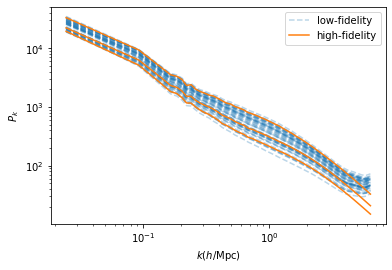

In [9]:
# visualize training spectra
for i,y_train in enumerate(data.Y_train[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="low-fidelity", color="C0", ls='--', alpha=0.3)
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C0", ls='--', alpha=0.3)
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")

The above plot shows 3 HR spectra and 50 LR spectra.

Text(0, 0.5, '$P_{k}$')

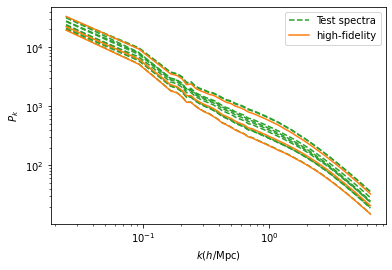

In [10]:
# visualize the testing data
# visualize training spectra
for i,y_train in enumerate(data.Y_test[0]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="Test spectra", color="C2", ls='--')
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C2", ls='--')
for i,y_train in enumerate(data.Y_train[1]):
    if i == 0:
        plt.loglog(10**data.kf, 10**y_train, label="high-fidelity", color="C1")
    else:
        plt.loglog(10**data.kf, 10**y_train, color="C1")
plt.legend()
plt.xlabel(r"$k (h/\mathrm{Mpc})$")
plt.ylabel(r"$P_{k}$")

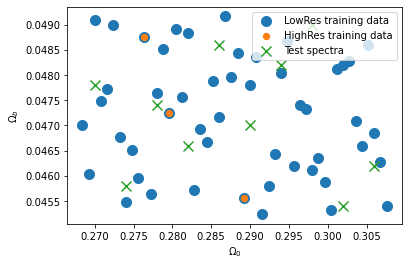

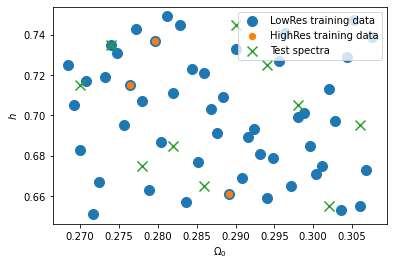

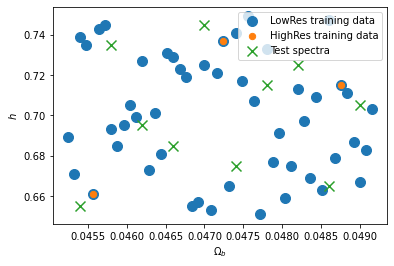

In [11]:
# nested training inputs
plot_parameters(
    [data.X_train[0][:, :3], data.X_train[1][:, :3]],
    [data.X_test[0][:, :3]],
    parameter_names=[r"$\Omega_0$", r"$\Omega_b$", r"$h$"],
)

## Building emulators

In [12]:
# only support 2 fidelities now
n_fidelities = 2
n_optimization_restarts = 5 # repeat optimizations and choose the best one; more is better.
                            # recommend: >= 30

In [13]:
# Multi-fidelity
# linear multi-fidelity
ar1 = SingleBinLinearGP(
    data.X_train_norm,
    data.Y_train_norm,
    kernel_list=None,
    n_fidelities=n_fidelities,
)
# non-linear multi-fidelity
nargp = SingleBinNonLinearGP(
    data.X_train_norm,
    data.Y_train_norm,
    n_fidelities=n_fidelities,
    n_samples=500,
    optimization_restarts=n_optimization_restarts,
)

# Single-fidelity
# high-fidelity only emulator
hf_only = SingleBinGP(data.X_train_norm[-1], data.Y_train[-1])
lf_only = SingleBinGP(data.X_train_norm[0], data.Y_train[0])

In [14]:
%%capture
# optimize each model
ar1.optimize(n_optimization_restarts=n_optimization_restarts)
nargp.optimize()
hf_only.optimize_restarts(n_optimization_restarts=n_optimization_restarts)
lf_only.optimize_restarts(n_optimization_restarts=n_optimization_restarts)

## Predictions

In [15]:
# testing set
means_ar1, vars_ar1, pred_exacts_ar1 = validate_mf(data, model=ar1)
means_nargp, vars_nargp, pred_exacts_nargp = validate_mf(data, model=nargp)
means_hfonly, vars_hfonly, pred_exacts_hfonly = validate_sf(data, model=hf_only)
means_lfonly, vars_lfonly, pred_exacts_lfonly = validate_sf(data, model=lf_only)

MFEmulators (50LR-3HR) versus High-Fidelity only emulator (w/ 3 HR)

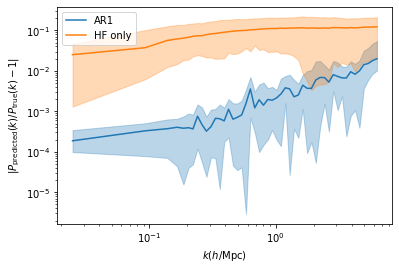

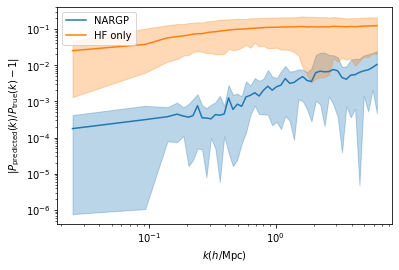

In [16]:
do_emulator_error_plots(
    data,
    means_ar1,
    means_hfonly,
    pred_exacts_ar1,
    pred_exacts_hfonly,
    label_mf="AR1",
    label_sf="HF only",
    figure_name="ar1",
)
do_emulator_error_plots(
    data,
    means_nargp,
    means_hfonly,
    pred_exacts_nargp,
    pred_exacts_hfonly,
    label_mf="NARGP",
    label_sf="HF only",
    figure_name="nargp",
)


MFEmulators (50LR-3HR) versus Low-Fidelity only emulator (w/ 50 LR)

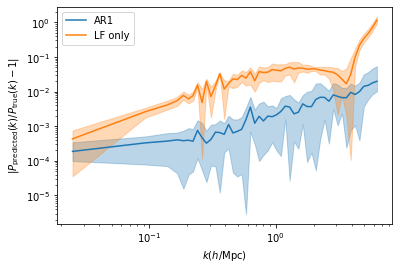

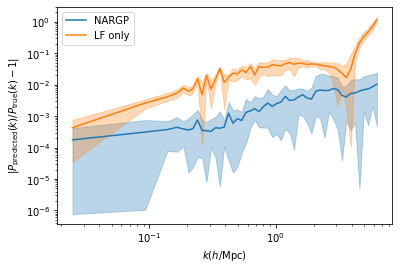

In [17]:
# versus LF
do_emulator_error_plots(
    data,
    means_ar1,
    means_lfonly,
    pred_exacts_ar1,
    pred_exacts_lfonly,
    label_mf="AR1",
    label_sf="LF only",
    figure_name="ar1_lf",
)
do_emulator_error_plots(
    data,
    means_nargp,
    means_lfonly,
    pred_exacts_nargp,
    pred_exacts_lfonly,
    label_mf="NARGP",
    label_sf="LF only",
    figure_name="nargp_lf",
)

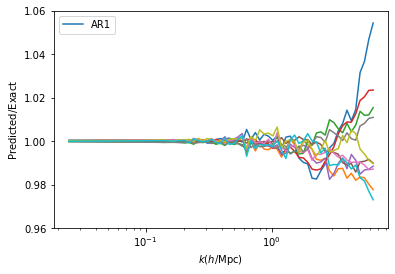

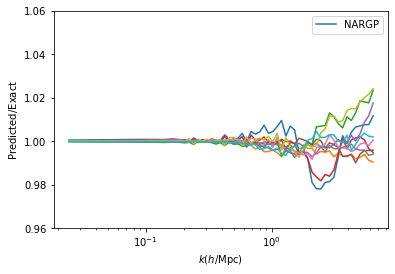

In [18]:
# pred/exact plot
do_pred_exact(data, means_ar1, pred_exacts_ar1, label_mf="AR1", figure_name="ar1")
do_pred_exact(
    data, means_nargp, pred_exacts_nargp, label_mf="NARGP", figure_name="nargp"
)